In [111]:
import numpy as np
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt

In [112]:
nodes_gpd = gpd.read_file('./wegengraaf2/points.shp')
lines_gpd = gpd.read_file('./wegengraaf2/lines.shp')

In [113]:
gf = nx.Graph()

for _, k in nodes_gpd.iterrows():
    gf.add_node(int(k['nodeID']),
                x=k['geometry'].x,
                y=k['geometry'].y,
                stad_naam=k['stad_naam'],
                is_auto_br=k['is_auto_br'],
                spawn_hoev=k['spawn_hoev'])

for _, row in lines_gpd.iterrows():
    gf.add_edge(int(row['node_start']), int(row['node_end']),
                wegnr=row['wegnr'],
                length=row['length'],
                maxshd=row['maxshd'],
                nbanen=row['nbanen'])
    
gfd = nx.DiGraph(gf)

In [114]:
def weight_edge_min(f, t, attr):
    return attr['length']/attr['maxshd']/1000*60

def weight_edge_dist(f, t, attr):
    return attr['length']

In [122]:
%%time
dist = {}
paths = {}

for (n, (a, b)) in nx.all_pairs_dijkstra(gfd, weight=weight_edge_min):
    dist[n] = a
    paths[n] = b

CPU times: total: 125 ms
Wall time: 123 ms


### shortest path examples

In [121]:
from_node = 1000
to_node = 1001

In [127]:
(pair_dist, pair_path) = nx.single_source_dijkstra(gfd, from_node, to_node, weight=weight_edge_min)
print(pair_dist, pair_path)

19.354978988448625 [1000, 6, 204, 249, 206, 192, 193, 146, 1001]


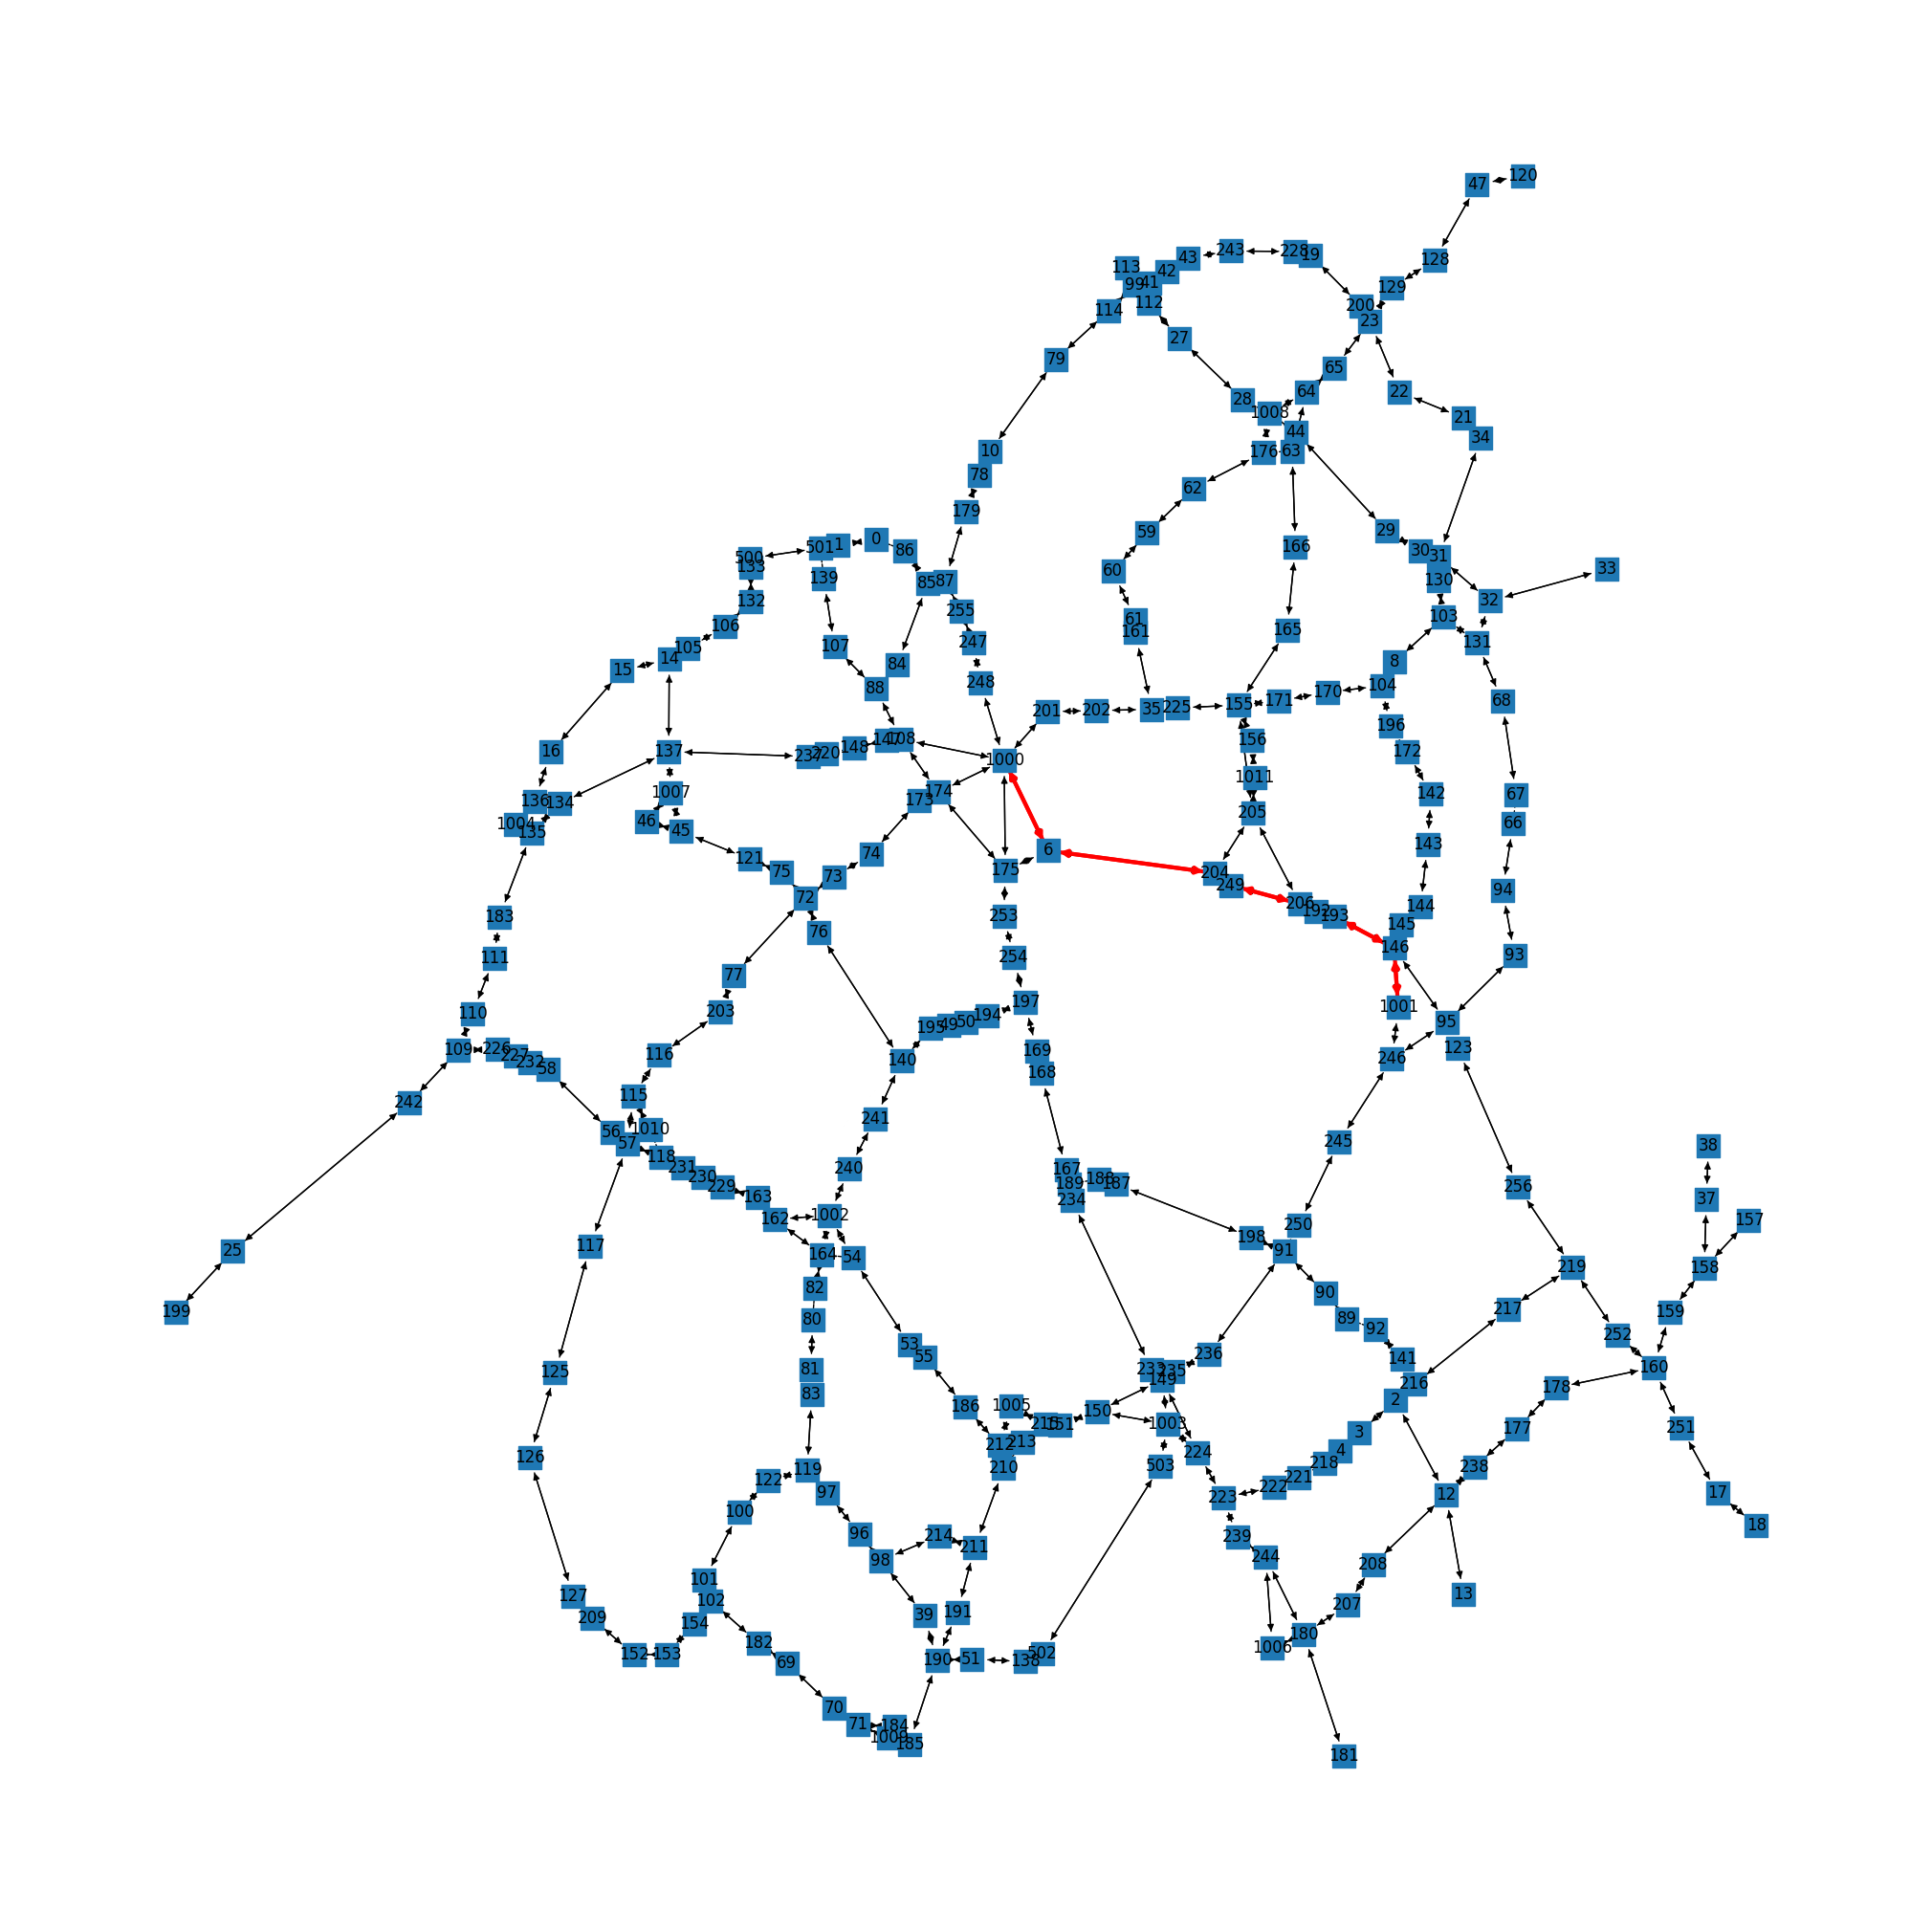

In [125]:
plt.figure(figsize=(20, 20))
nx.draw(gfd, pos={n: [gfd.nodes[n]['x'], gfd.nodes[n]['y']] for n in list(gfd.nodes)}, with_labels=True, node_shape='s')
# nx.draw(subgr, pos={n: [gfd.nodes[n]['x'], gfd.nodes[n]['y']] for n in list(gfd.nodes)})

path = paths[from_node][to_node]
subgr = nx.DiGraph(gfd.subgraph(path))
nx.draw_networkx_edges(subgr, pos={n: [gfd.nodes[n]['x'], gfd.nodes[n]['y']] for n in list(gfd.nodes)}, edge_color='red', width=3)

plt.show()